In [67]:
import numpy as np
import pandas as pd
import warnings
from sklearn import *
from imblearn.over_sampling import RandomOverSampler
from catboost import CatBoostClassifier
import lightgbm as lgb
import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline

In [68]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [69]:
data = pd.read_csv('online_shoppers_intention.csv');
#data.describe(include='all')
data

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.000000,0.100000,0.000000,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.200000,0.200000,0.000000,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.050000,0.140000,0.000000,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.020000,0.050000,0.000000,0.0,Feb,3,3,1,4,Returning_Visitor,True,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,3,145.0,0,0.0,53,1783.791667,0.007143,0.029031,12.241717,0.0,Dec,4,6,1,1,Returning_Visitor,True,False
12326,0,0.0,0,0.0,5,465.750000,0.000000,0.021333,0.000000,0.0,Nov,3,2,1,8,Returning_Visitor,True,False
12327,0,0.0,0,0.0,6,184.250000,0.083333,0.086667,0.000000,0.0,Nov,3,2,1,13,Returning_Visitor,True,False
12328,4,75.0,0,0.0,15,346.000000,0.000000,0.021053,0.000000,0.0,Nov,2,2,3,11,Returning_Visitor,False,False


In [70]:

#####################################################################################
# С помощью LabelEncoder() переводим категориальные(или номинальные) признаки в числовой формат

#le = preprocessing.LabelEncoder()
#for i in ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Month', 'Revenue']:
#    data[i] = le.fit_transform(data[i])

#####################################################################################
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

columns = ['Administrative','Administrative_Duration','Informational','Informational_Duration','ProductRelated','ProductRelated_Duration', 'BounceRates', 'ExitRates', 'PageValues','SpecialDay' ]
data_new = data.loc[:, columns].copy(deep=True).reset_index(drop=True)
# Тут мы все числовые(или номинальные) признаки нормализуем (-1,1)
#data_new = data[columns]
from sklearn.preprocessing import StandardScaler
features = data_new[columns]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)
data_new[columns] = features


# Бинаризуемый целевой признак

le = preprocessing.LabelEncoder()
data['Revenue'] = le.fit_transform(data['Revenue'])

# Применяем One-hot-encoding ко всем категориальным(или номинальным)

for i in ['OperatingSystems', 'Browser', 'Region', 'TrafficType', 'VisitorType', 'Weekend', 'Month',]:
    data_new = data_new.join(pd.get_dummies(data[i], prefix=i))
    
data_new = data_new.join(data['Revenue'])
data_new

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Revenue
0,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0,1,0,0,0,0,0,0,0,0
1,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.590903,-0.457683,1.171473,-0.317178,-0.308821,...,0,1,0,0,0,0,0,0,0,0
2,-0.696993,-0.457191,-0.396478,-0.244931,-0.691003,-0.624348,3.667189,3.229316,-0.317178,-0.308821,...,0,1,0,0,0,0,0,0,0,0
3,-0.696993,-0.457191,-0.396478,-0.244931,-0.668518,-0.622954,0.573535,1.994610,-0.317178,-0.308821,...,0,1,0,0,0,0,0,0,0,0
4,-0.696993,-0.457191,-0.396478,-0.244931,-0.488636,-0.296430,-0.045196,0.142551,-0.317178,-0.308821,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,-0.310366,-0.288966,0.342125,-0.308821,...,1,0,0,0,0,0,0,0,0,0
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,-0.457683,-0.447364,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,1.261014,0.897093,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,-0.457683,-0.453140,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0


In [80]:
data_train = data_new.loc[0.3*data_new.shape[0]:1*data_new.shape[0]]
data_test = data_new.loc[0.0*data_new.shape[0]:0.3*data_new.shape[0]]

ros = RandomOverSampler(random_state=0)
X_train = data_train.loc[:,data_train.columns != 'Revenue'].values
Y_train = data_train['Revenue'].values

# Oversampling train(70% Dataset) Для баланса между true и false целевого признака Revenue

X_overs_train, Y_overs_train = ros.fit_sample(X_train, Y_train)

# к test oversampling не применяем 
X_test = data_test.loc[:,data_test.columns != 'Revenue'].values
Y_test = data_test['Revenue'].values

from collections import Counter
cont = Counter(Y_test)
cont1 = Counter(Y_train)
print(cont[0], cont[1])
data_train
#X_overs_test, Y_overs_test = ros.fit_sample(X_test, Y_test)
#X_overs_train.loc[Y_overs_train[0] == 1]

3333 367


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,...,Month_Dec,Month_Feb,Month_Jul,Month_June,Month_Mar,Month_May,Month_Nov,Month_Oct,Month_Sep,Revenue
3699,0.507228,-0.191312,-0.396478,-0.244931,-0.578577,-0.533942,-0.199879,-0.114679,-0.317178,-0.308821,...,0,0,0,0,0,1,0,0,0,0
3700,-0.696993,-0.457191,-0.396478,-0.244931,0.635624,-0.118884,-0.317857,-0.369003,-0.317178,2.707630,...,0,0,0,0,0,1,0,0,0,0
3701,-0.696993,-0.457191,-0.396478,-0.244931,-0.533607,-0.421326,-0.457683,-0.592393,-0.317178,-0.308821,...,0,0,0,0,0,1,0,0,0,0
3702,-0.696993,-0.457191,-0.396478,-0.244931,-0.556092,-0.150892,-0.457683,-0.543397,0.489780,1.702146,...,0,0,0,0,0,1,0,0,0,1
3703,1.711449,1.109045,-0.396478,-0.244931,-0.286270,-0.337514,-0.457683,-0.728440,-0.007820,-0.308821,...,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.206173,0.363075,-0.396478,-0.244931,0.478227,0.307822,-0.310366,-0.288966,0.342125,-0.308821,...,1,0,0,0,0,0,0,0,0,0
12326,-0.696993,-0.457191,-0.396478,-0.244931,-0.601062,-0.380957,-0.457683,-0.447364,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0
12327,-0.696993,-0.457191,-0.396478,-0.244931,-0.578577,-0.528063,1.261014,0.897093,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0
12328,0.507228,-0.032916,-0.396478,-0.244931,-0.376210,-0.443536,-0.457683,-0.453140,-0.317178,-0.308821,...,0,0,0,0,0,0,1,0,0,0


In [82]:
def perf_measure(y_actual, y_hat):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_hat)): 
        if y_actual[i]==y_hat[i]==1:
           TP += 1
        if y_hat[i]==1 and y_actual[i]!=y_hat[i]:
           FP += 1
        if y_actual[i]==y_hat[i]==0:
           TN += 1
        if y_hat[i]==0 and y_actual[i]!=y_hat[i]:
           FN += 1
    return (TP,TN)
    #/cont[1],/cont[0]
    #return(TP, FP, TN, FN)
    
from sklearn.metrics import f1_score

In [83]:
# Случайный лес

RandomForest = ensemble.RandomForestClassifier()
RandomForest.fit(X_overs_train, Y_overs_train)
pr = RandomForest.predict(X_test)
acc = metrics.accuracy_score(Y_test, pr)
print('RandomForest: {:6.4}'.format(acc))
TPosTNeg = perf_measure(Y_test,pr)
print('True Positive Rate: ',TPosTNeg[0])
print('True Negative Rate: ',TPosTNeg[1])
f1 = f1_score(Y_test, pr)
print('F1 score: {:6.4}'.format(f1))
#print(TPosTNeg[0])

RandomForest:  0.943
True Positive Rate:  248
True Negative Rate:  3241
F1 score: 0.7016


In [76]:
XGBoost = xgb.XGBClassifier()
XGBoost.fit(X_overs_train, Y_overs_train)
pr = XGBoost.predict(X_test)
acc = metrics.accuracy_score(Y_test, pr)
print('XGBoost: {:6.4}'.format(acc))
TPosTNeg = perf_measure(Y_test,pr)
print('True Positive Rate: ',TPosTNeg[0])
print('True Negative Rate: ',TPosTNeg[1])
f1 = f1_score(Y_test, pr)
print('F1 score: {:6.4}'.format(f1))

XGBoost: 0.9416
True Positive Rate:  0.8147138964577657
True Negative Rate:  0.9555955595559555
F1 score: 0.7346


In [77]:
CatBoost = CatBoostClassifier(logging_level='Silent', learning_rate=0.05)
CatBoost.fit(X_overs_train, Y_overs_train)
pr = CatBoost.predict(X_test)
acc = metrics.accuracy_score(Y_test, pr)
print('CatBoost: {:6.4}'.format(acc))
TPosTNeg = perf_measure(Y_test,pr)
print('True Positive Rate: ',TPosTNeg[0])
print('True Negative Rate: ',TPosTNeg[1])
f1 = f1_score(Y_test, pr)
print('F1 score: {:6.4}'.format(f1))

CatBoost: 0.9411
True Positive Rate:  0.8610354223433242
True Negative Rate:  0.9498949894989499
F1 score: 0.7435


In [78]:
LightGBM = lgb.LGBMClassifier(verbosity=-1)
LightGBM.fit(X_overs_train, Y_overs_train)
pr = LightGBM.predict(X_test)
acc = metrics.accuracy_score(Y_test, pr)
print('LightGBM: {:6.4}'.format(acc))
TPosTNeg = perf_measure(Y_test,pr)
print('True Positive Rate: ',TPosTNeg[0])
print('True Negative Rate: ',TPosTNeg[1])
f1 = f1_score(Y_test, pr)
print('F1 score: {:6.4}'.format(f1))

LightGBM: 0.9376
True Positive Rate:  0.8828337874659401
True Negative Rate:  0.9435943594359436
F1 score: 0.7372


In [79]:
Tree = tree.DecisionTreeClassifier(max_depth=5.9, criterion='entropy')
#prediction = model_selection.cross_val_predict(Tree, X_oversampled, Y_oversampled, )
Tree.fit(X_overs_train, Y_overs_train)
pr = Tree.predict(X_test)
acc = metrics.accuracy_score(Y_test, pr)
print('Tree: {:6.4}'.format(acc))
TPosTNeg = perf_measure(Y_test,pr)
print('True Positive Rate: ',TPosTNeg[0])
print('True Negative Rate: ',TPosTNeg[1])
f1 = f1_score(Y_test, pr)
print('F1 score: {:6.4}'.format(f1))

Tree: 0.9257
True Positive Rate:  0.888283378746594
True Negative Rate:  0.9297929792979298
F1 score: 0.7033


In [331]:
method = lgb.LGBMClassifier(verbosity=-1)
# важность признаков
importance = {}
for c in data_new.columns:
    if c == 'Revenue': continue
    # пытаемся предсказать результат, используя только один столбец
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        prediction = model_selection.cross_val_predict(method, 
                                                       data_new[c].values.reshape(-1,1),
                                                       data_new['Revenue'])
    importance[c] = metrics.accuracy_score(data_new['Revenue'], prediction)
cols = list(importance.keys())
fi = np.array([importance[c] for c in cols])
fi = (fi-fi.min())/(fi.max()-fi.min())

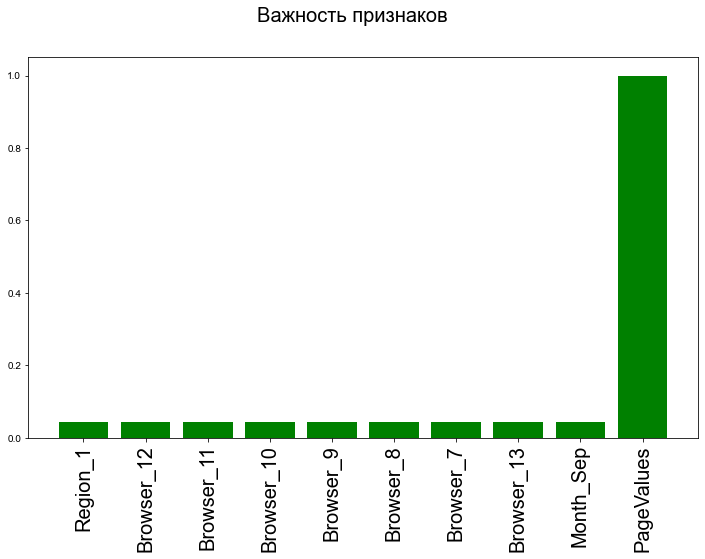

In [332]:
ind = np.argsort(fi)
fi = fi[ind]
cols = np.array(cols)[ind]
fig = plt.figure()
plt.rc('font', family='Arial')
plt.rcParams['xtick.labelsize'] = 20
plt.bar(np.arange(len(cols[-10:])), fi[-10:], color='g')
plt.xticks(np.arange(len(cols[-10:])), cols[-10:], rotation='vertical')
_ = fig.suptitle('Важность признаков', fontsize=20)